In [5]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
def cpp_outputs_plotting(complexity_path, convergence_path, validation_value=None):
    # Load data
    df_comp = pd.read_csv(complexity_path)
    df_conv = pd.read_csv(convergence_path)

    # Extract columns for convergence plots
    L = df_conv['level'].values
    del1 = df_conv['ave_Pf-Pc'].values
    del2 = df_conv['ave_Pf'].values
    var1 = df_conv['var_Pf-Pc'].values
    var2 = df_conv['var_Pf'].values
    kur1 = df_conv['kurtosis'].values
    chk1 = df_conv['check'].values
    cost = df_conv['cost'].values
    N = df_conv['N'].iloc[0]

    # Extract columns for complexity plots
    Eps = df_comp['eps'].values
    mlmc_estimate = df_comp['mlmc_estimate'].values
    mlmc_cost = df_comp['mlmc_cost'].values
    std_mc_cost = df_comp['std_mc_cost'].values
    Nl_cols = [c for c in df_comp.columns if c.startswith("Nl_")]
    Yls_cols = [c for c in df_comp.columns if c.startswith("Yl_")]
    Vls_cols = [c for c in df_comp.columns if c.startswith("Vl_")]
    Nls = df_comp[Nl_cols].values.astype(float).T  # shape (n_levels, n_eps)
    Yls = df_comp[Yls_cols].values.astype(float).T
    Vls = df_comp[Vls_cols].values.astype(float).T


    # -- Start plotting --
    nrows = 6
    fig = plt.figure(figsize=(10, 3.5 * nrows))
    gs = gridspec.GridSpec(nrows, 2, figure=fig)

    axs = []
    for row in range(0, 3):
        axs.append(fig.add_subplot(gs[row, 0]))
        axs.append(fig.add_subplot(gs[row, 1]))
    
    var_ax, mean_ax, chk_ax, kur_ax, count_ax, cost_ax = axs
    validation_ax = fig.add_subplot(gs[3, :])
    conv_ax = fig.add_subplot(gs[4, :])
    results_convergence_ax = fig.add_subplot(gs[5, :])

    var_ax.plot(L, np.log2(var2), '-*', label='P_l')
    var_ax.plot(L[1:], np.log2(var1[1:]), '--*', label='P_l - P_{l-1}')
    var_ax.set_xlabel(r'level $l$')
    var_ax.set_ylabel(r'$\log_2$ variance')
    var_ax.legend(loc='upper right')

    mean_ax.plot(L, np.log2(np.abs(del2)), '-*', label='P_l')
    mean_ax.plot(L[1:], np.log2(np.abs(del1[1:])), '--*', label='P_l - P_{l-1}')
    mean_ax.set_xlabel(r'level $l$')
    mean_ax.set_ylabel(r'$\log_2 |\text{mean}|$')
    mean_ax.legend(loc='upper right')

    chk_ax.plot(L[1:] - 1e-9, chk1[1:], '--*')
    chk_ax.set_xlabel(r'level $l$')
    chk_ax.set_ylabel('consistency check')

    kur_ax.plot(L[1:] - 1e-9, kur1[1:], '--*')
    kur_ax.set_xlabel(r'level $l$')
    kur_ax.set_ylabel('kurtosis')

    for i, eps in enumerate(Eps):
        ls = np.arange(Nls[:,i].size)
        count_ax.semilogy(ls, Nls[:,i], '--o', label=fr'$\epsilon$={eps:.3g}')
    count_ax.set_xlabel(r'level $\ell$')
    count_ax.set_ylabel('$N_\\ell$')
    count_ax.legend()

    cost_ax.loglog(Eps, Eps**2 * std_mc_cost, '--o', label='Std MC')
    cost_ax.loglog(Eps, Eps**2 * mlmc_cost, '--x', label='MLMC')
    cost_ax.set_xlabel(r'accuracy $\epsilon$')
    cost_ax.set_ylabel(r'$\epsilon^2$ Cost')
    cost_ax.legend()


    # MLMC estimates
    mlmc_estimator = np.cumsum(del1)
    mlmc_se = np.sqrt(np.cumsum(var1) / N)
    validation_ax.errorbar(L, mlmc_estimator, yerr=mlmc_se, fmt='o-', capsize=5, elinewidth=1.2, color='blue', ecolor='lightblue',
                            label=r'MLMC estimates $\pm \sigma$ ')
    # Plot E[P_l] for context
    mc_se = np.sqrt(var2 / N)
    validation_ax.errorbar(L, del2, yerr=mc_se, fmt='s--', elinewidth=1.2, color='gray', ecolor='silver', label=r'MC estimates $\pm \sigma$')
    validation_ax.set_xlabel(r'Level $\ell$', fontsize=12)
    validation_ax.set_ylabel(r'Estimate', fontsize=12)
    validation_ax.tick_params(axis='both', which='major', labelsize=10)
    validation_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    validation_ax.spines['top'].set_visible(False)
    validation_ax.spines['right'].set_visible(False)
    validation_ax.set_title('Convergence of MLMC Estimate', fontsize=13)
    validation_ax.legend(loc='best', frameon=True, fontsize=11)
    if validation_value is not None:
        validation_ax.axhline(y=validation_value, linestyle='--', color='crimson', linewidth=2, label='Target QoI')

    conv_ax.plot(Eps, mlmc_estimate, '--*', label='MMLMC estimates')
    conv_ax.fill_between(
        Eps, mlmc_estimate - Eps, mlmc_estimate + Eps, color='crimson', alpha=0.2, label=r'$\pm \epsilon$'
    )
    if validation_value is not None:
        conv_ax.axhline(y=validation_value, linestyle='--', color='crimson', linewidth=2, label='Target QoI')
    conv_ax.set_xlabel(r'standard error, $\epsilon$')
    conv_ax.set_ylabel(r'MLMC estimate')
    conv_ax.invert_xaxis()
    conv_ax.legend()
    conv_ax.set_title("Estimator vs Error Target")

    for i, eps in enumerate(Eps):
        Nl = Nls[:,i]
        Yl = Yls[:,i]
        Vl = Vls[:,i]
        # Standard error per level
        se_array = np.sqrt(np.cumsum(Vl / Nl))
        # Cumulative sum of estimator
        cumulative_est = np.cumsum(Yl)
        results_convergence_ax.plot(np.arange(len(cumulative_est)), cumulative_est, '-o', label=fr'$\epsilon$ = {eps:.3g}')
        results_convergence_ax.fill_between(np.arange(len(cumulative_est)),
                                            cumulative_est - se_array,
                                            cumulative_est + se_array,
                                            alpha=0.2, linewidth=0)
    if validation_value is not None:
        results_convergence_ax.axhline(y=validation_value, linestyle='--', color='crimson', label='True QoI')
        results_convergence_ax.set_xlabel(r'Level $\ell$')
        results_convergence_ax.set_ylabel(r'Cumulative Estimate')
        results_convergence_ax.set_title('Cumulative MLMC estimate as levels are added')
        results_convergence_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        results_convergence_ax.legend()
    else:
        results_convergence_ax.text(0.2, 0.5, "Per-level MLMC estimators not found in CSV.", fontsize=13)

    plt.tight_layout()
    plt.show()

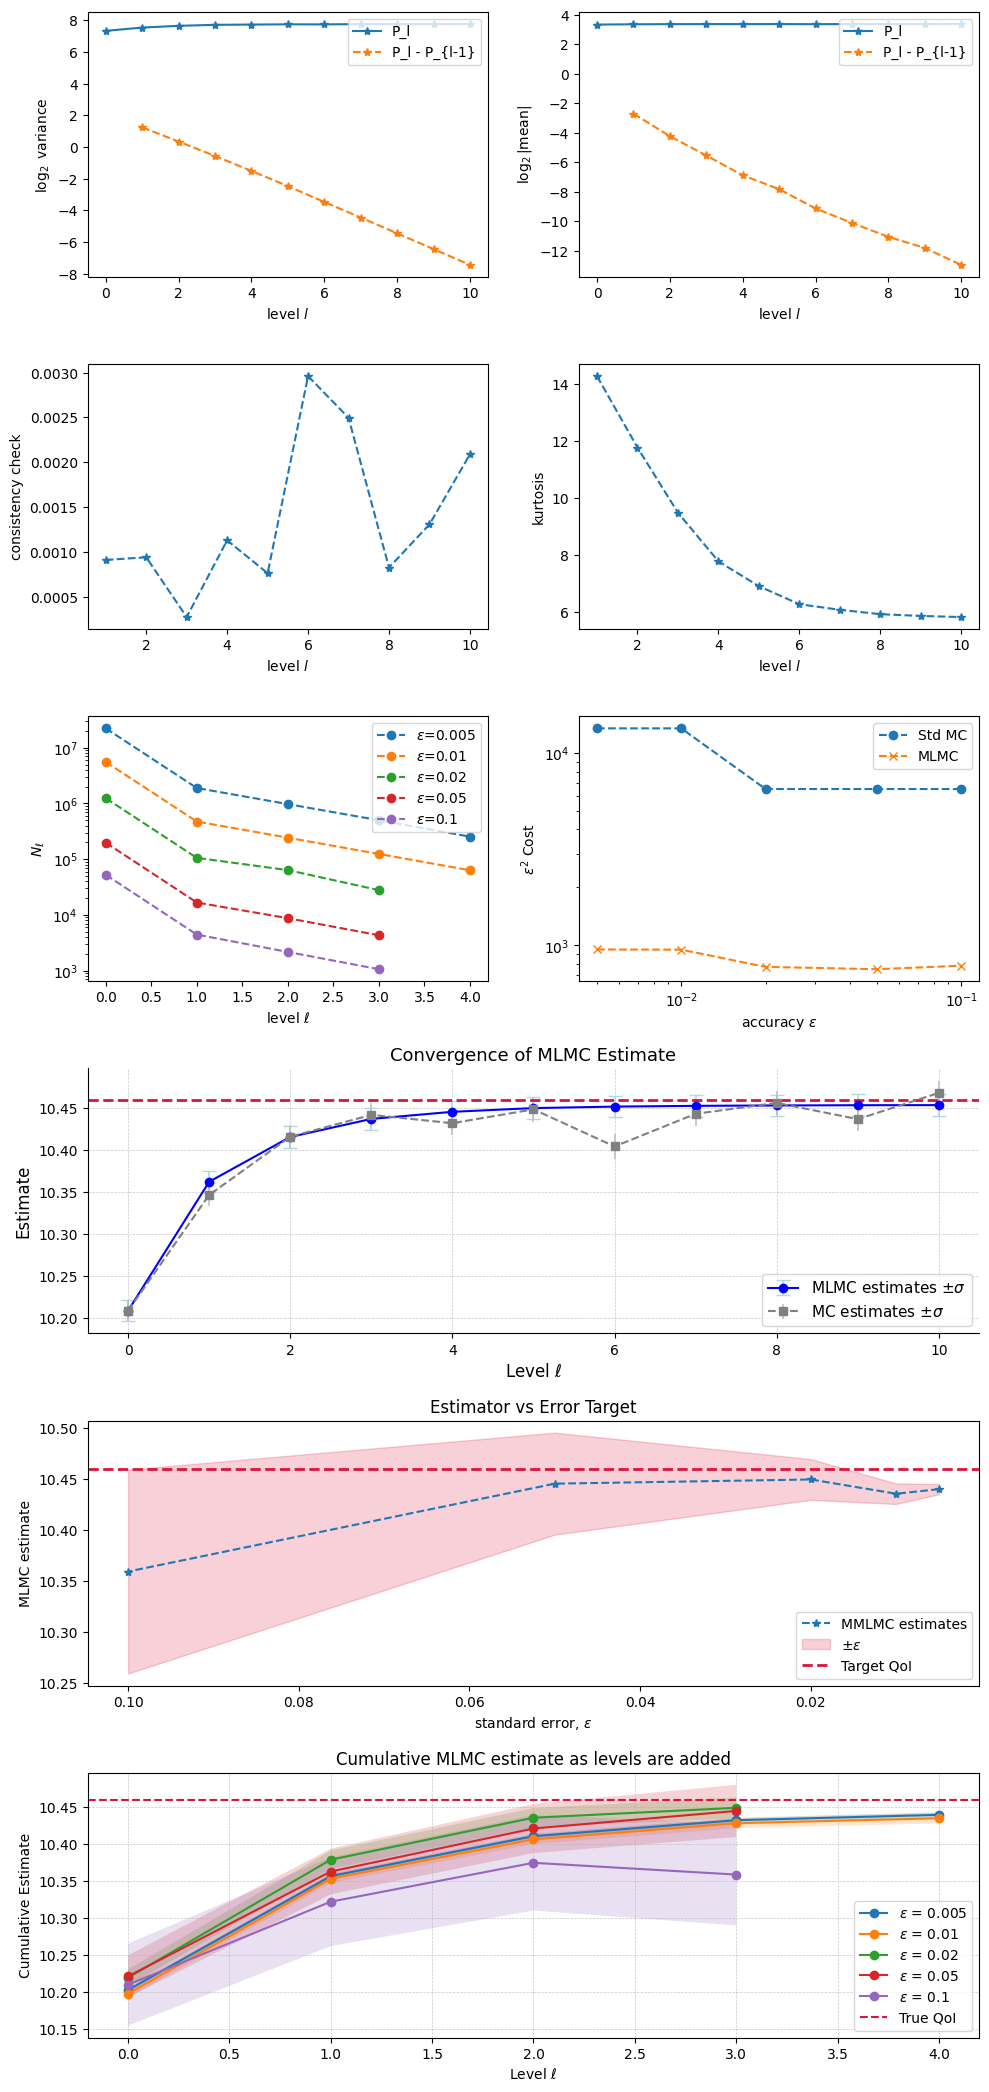

In [6]:
cpp_outputs_plotting(complexity_path='../mlmc_cpp/outputs/mlmc_complexity_gbm_euler.csv',
                    convergence_path='../mlmc_cpp/outputs/mlmc_convergence_gbm_euler.csv',
                    validation_value=10.46)

0.08333333319780166


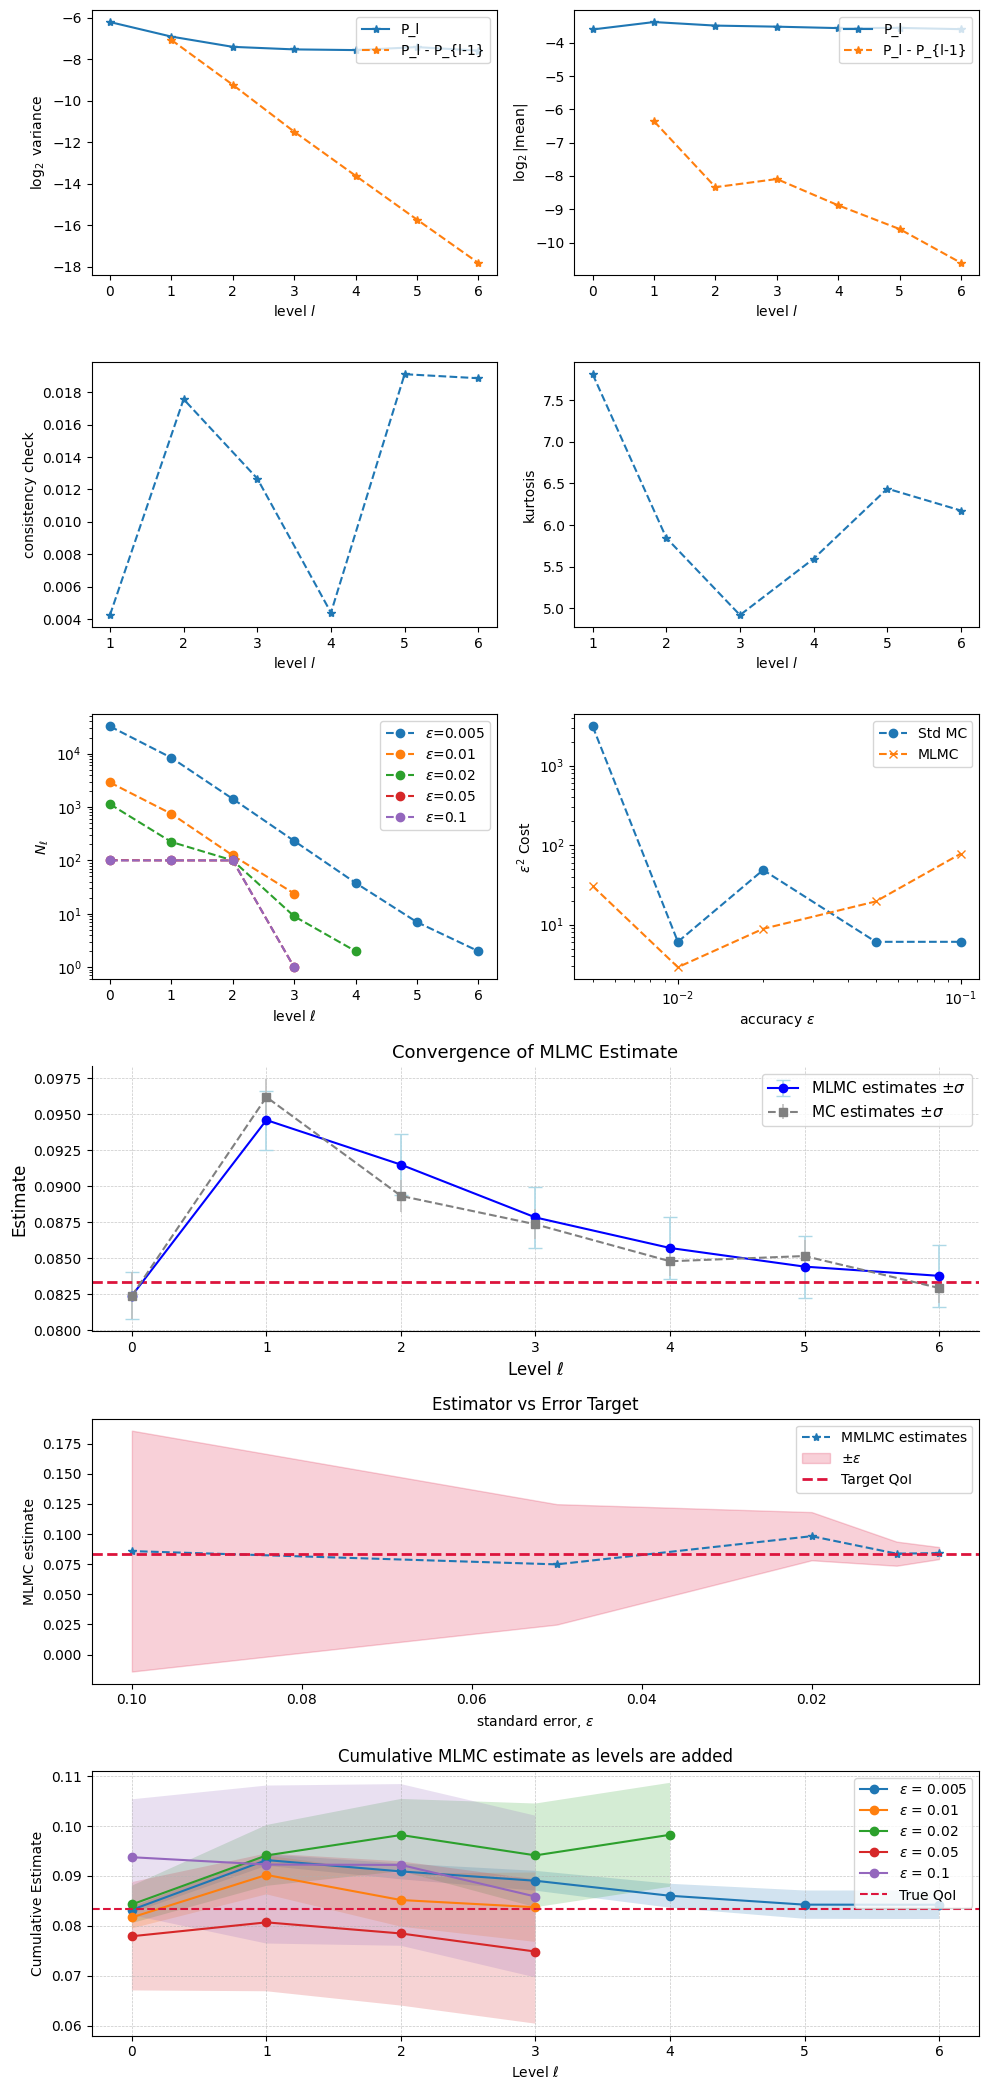

In [56]:
validation_value = 1/12 - np.exp(- 2 * np.pi**2) / (2 * np.pi**2)
print(validation_value)
cpp_outputs_plotting(complexity_path='../mlmc_cpp/outputs/mlmc_complexity_stoch_heat_eqn.csv',
                    convergence_path='../mlmc_cpp/outputs/mlmc_convergence_stoch_heat_eqn.csv',
                    validation_value=validation_value) 

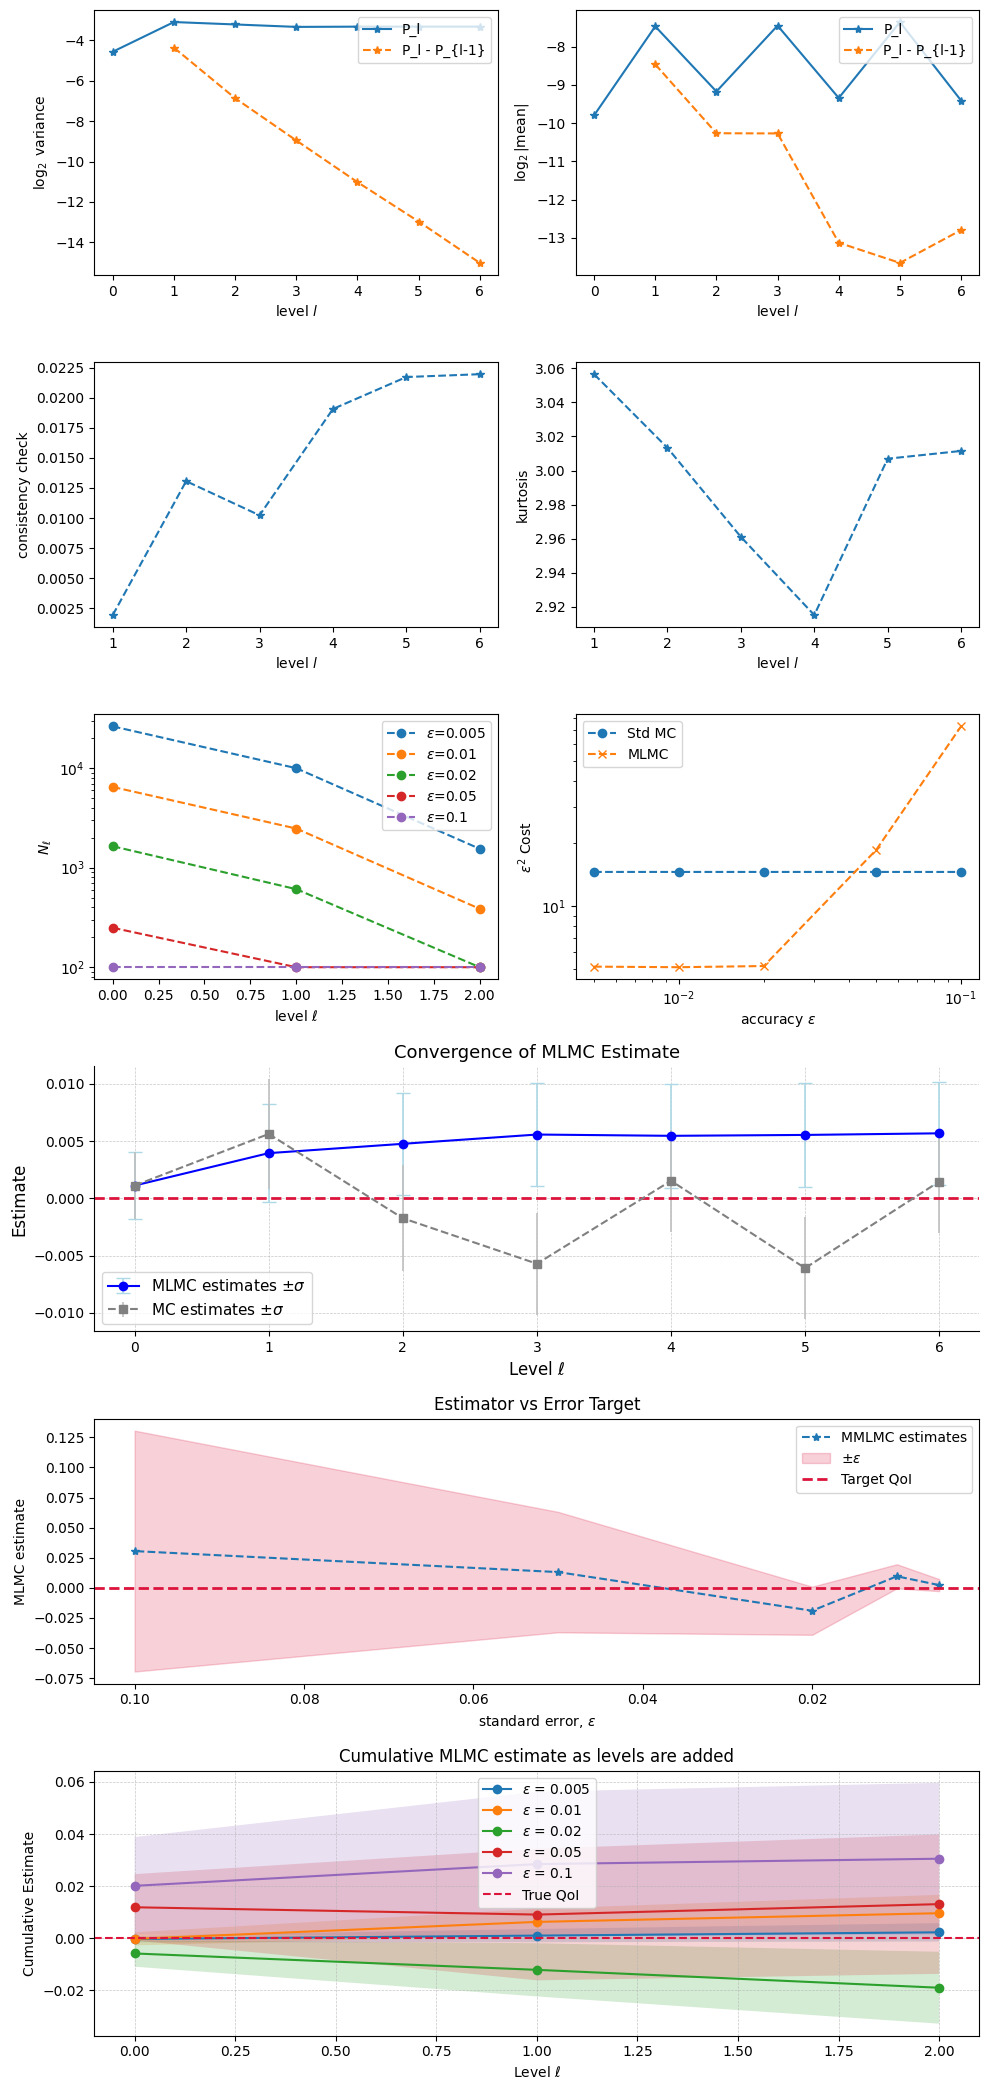

In [55]:
cpp_outputs_plotting(complexity_path='../mlmc_cpp/outputs/mlmc_complexity_stoch_heat_eqn_fourier_mode.csv',
                    convergence_path='../mlmc_cpp/outputs/mlmc_convergence_stoch_heat_eqn_fourier_mode.csv',
                    validation_value=0.0)

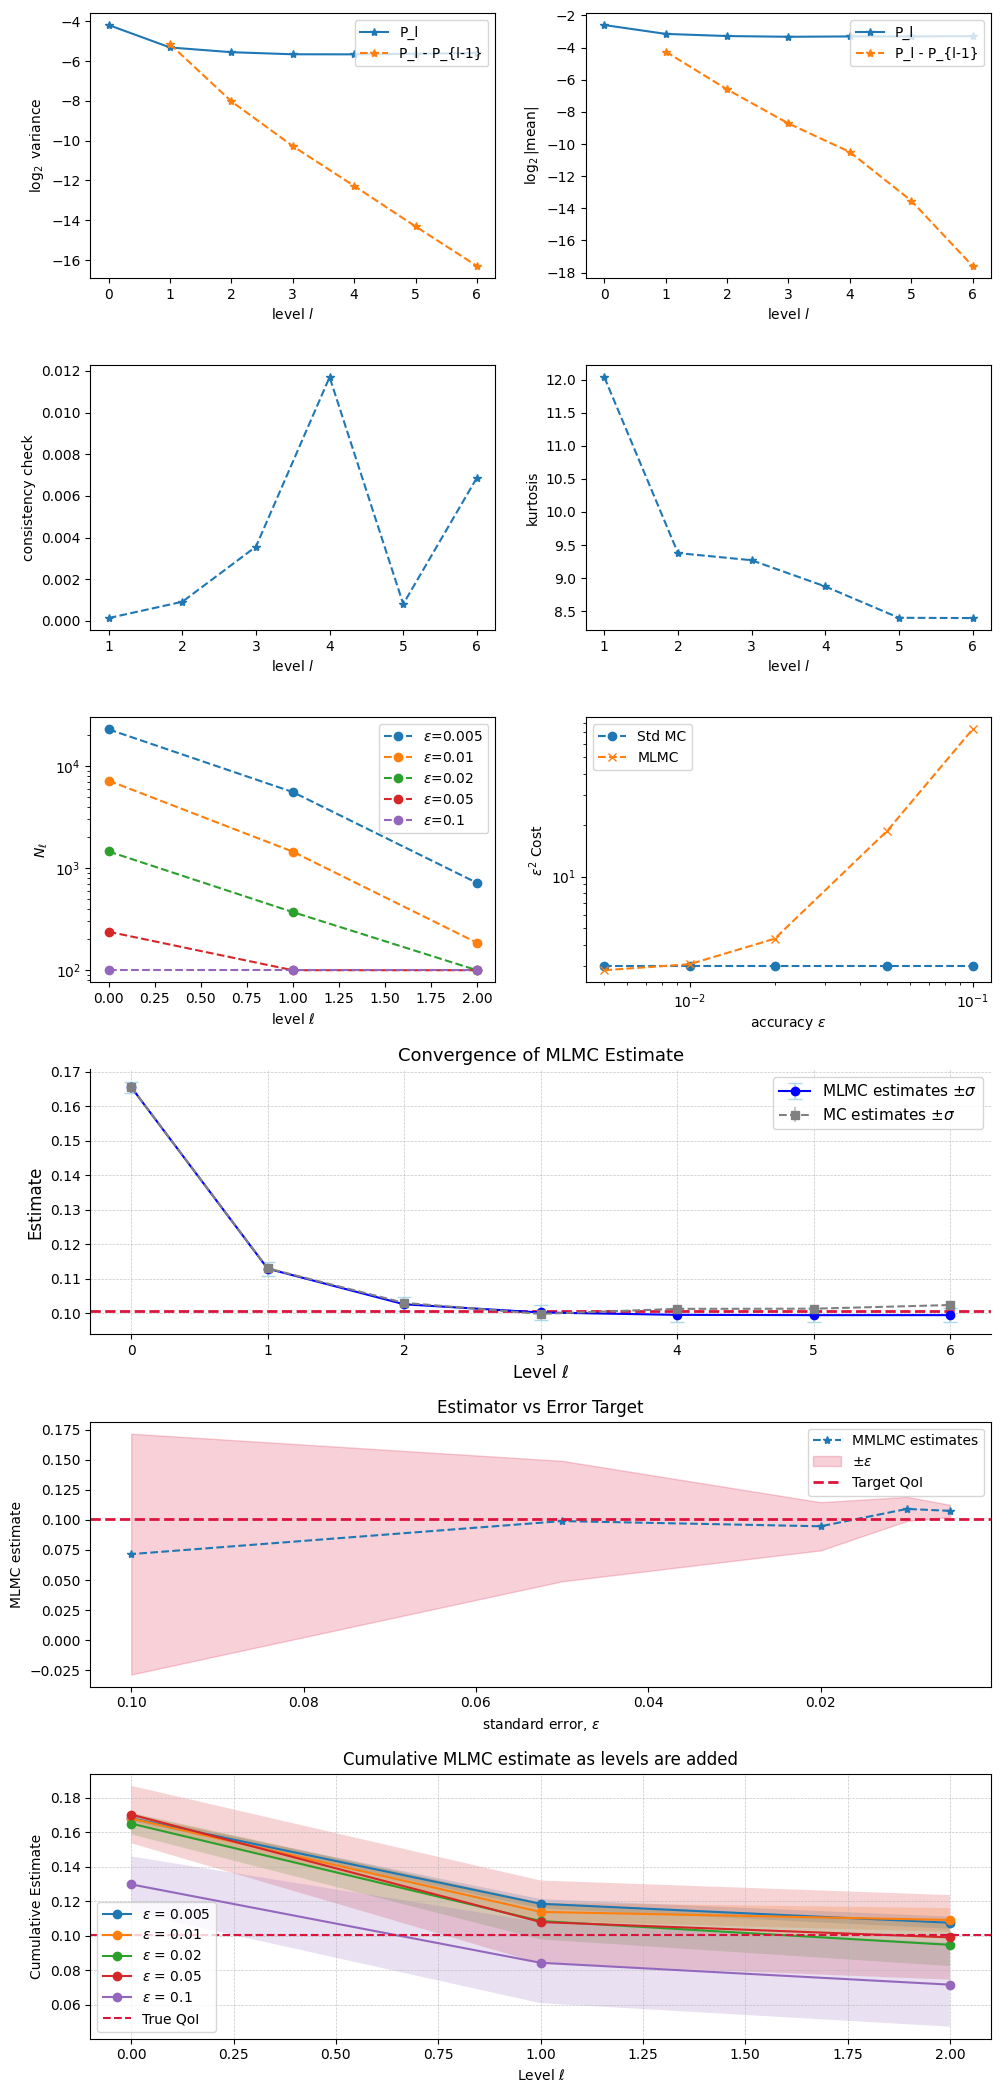

In [7]:
true_var = lambda n: (1 - np.exp(- 2 * n**2 * np.pi**2 * 0.25)) / (n**2 * np.pi**2)
cpp_outputs_plotting(complexity_path='../mlmc_cpp/outputs/mlmc_complexity_stoch_heat_eqn_fourier_mode_var.csv',
                    convergence_path='../mlmc_cpp/outputs/mlmc_convergence_stoch_heat_eqn_fourier_mode_var.csv',
                    validation_value=true_var(1))

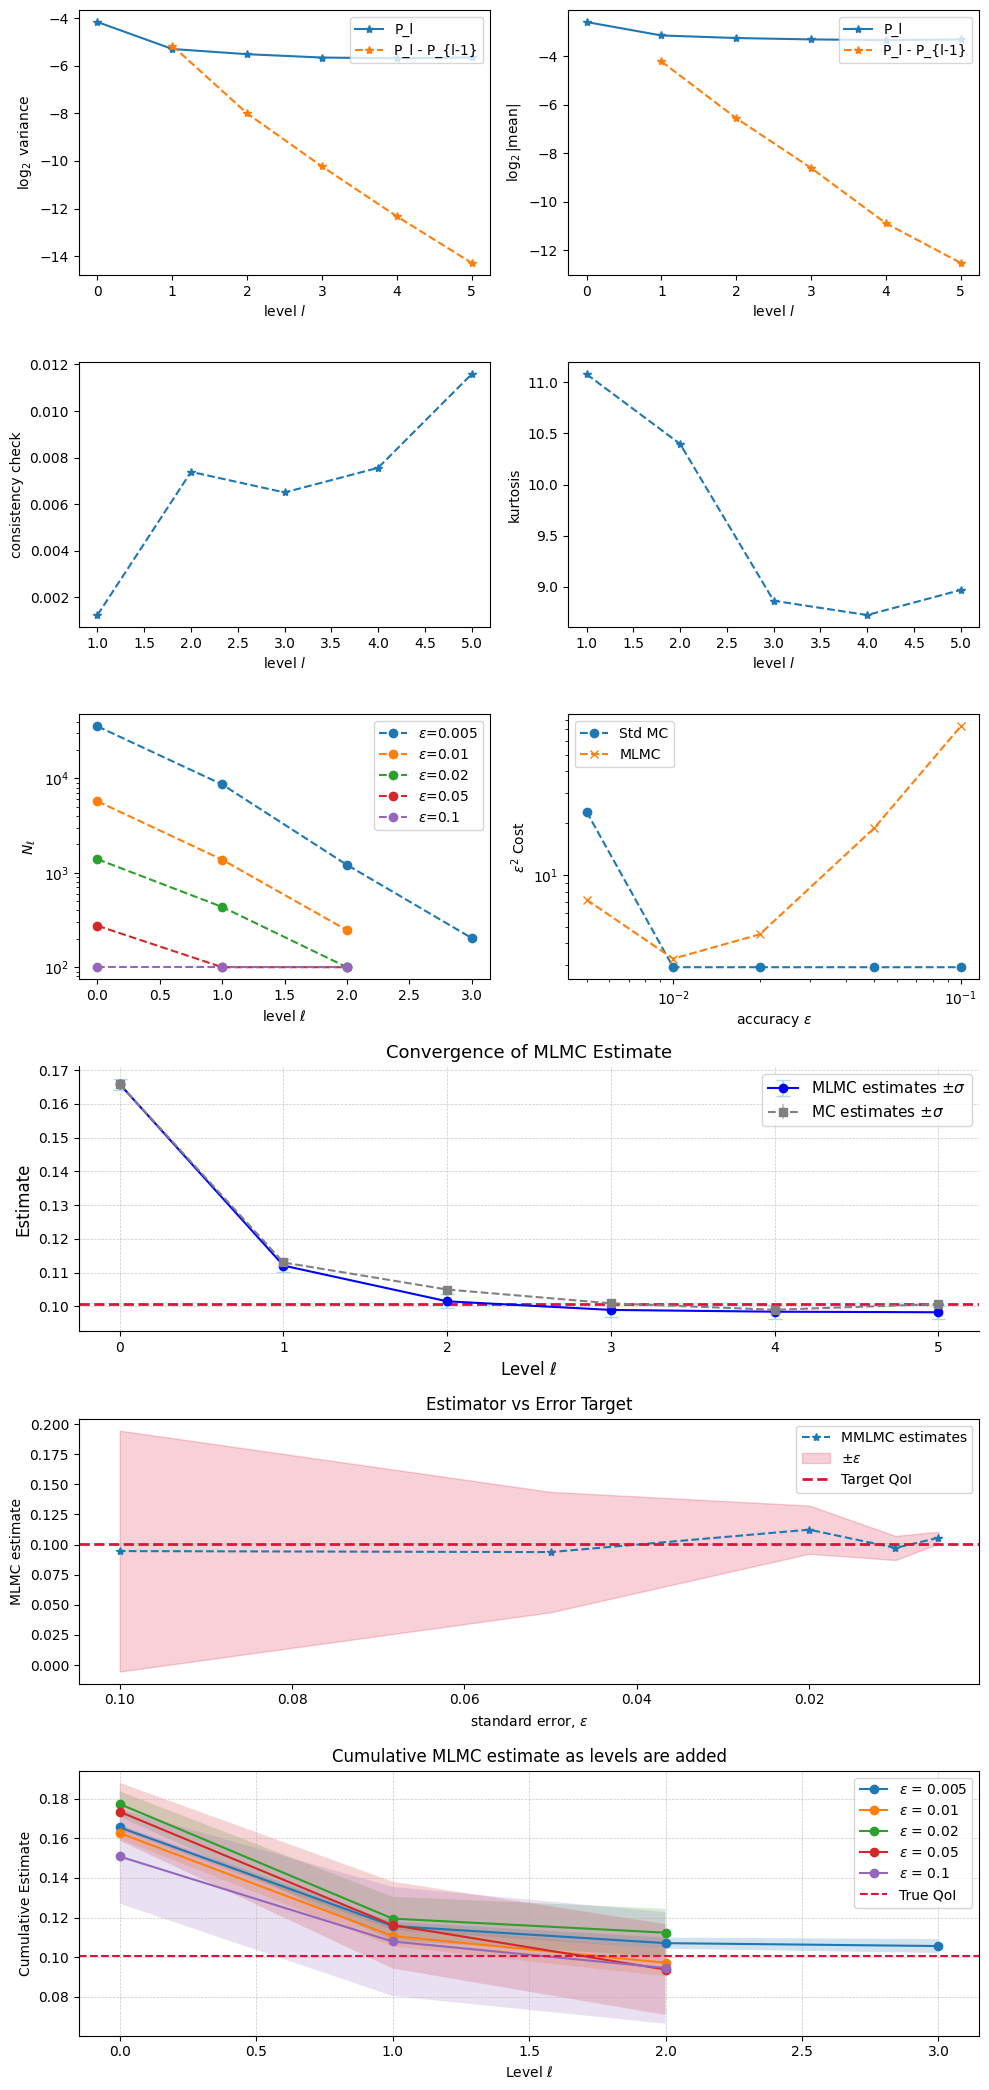

In [8]:
true_var = lambda n: (1 - np.exp(- 2 * n**2 * np.pi**2 * 0.25)) / (n**2 * np.pi**2)
cpp_outputs_plotting(complexity_path='../mlmc_cpp/outputs/mlmc_complexity_stoch_heat_eqn_fourier_mode_var_cc.csv',
                    convergence_path='../mlmc_cpp/outputs/mlmc_convergence_stoch_heat_eqn_fourier_mode_var_cc.csv',
                    validation_value=true_var(1))

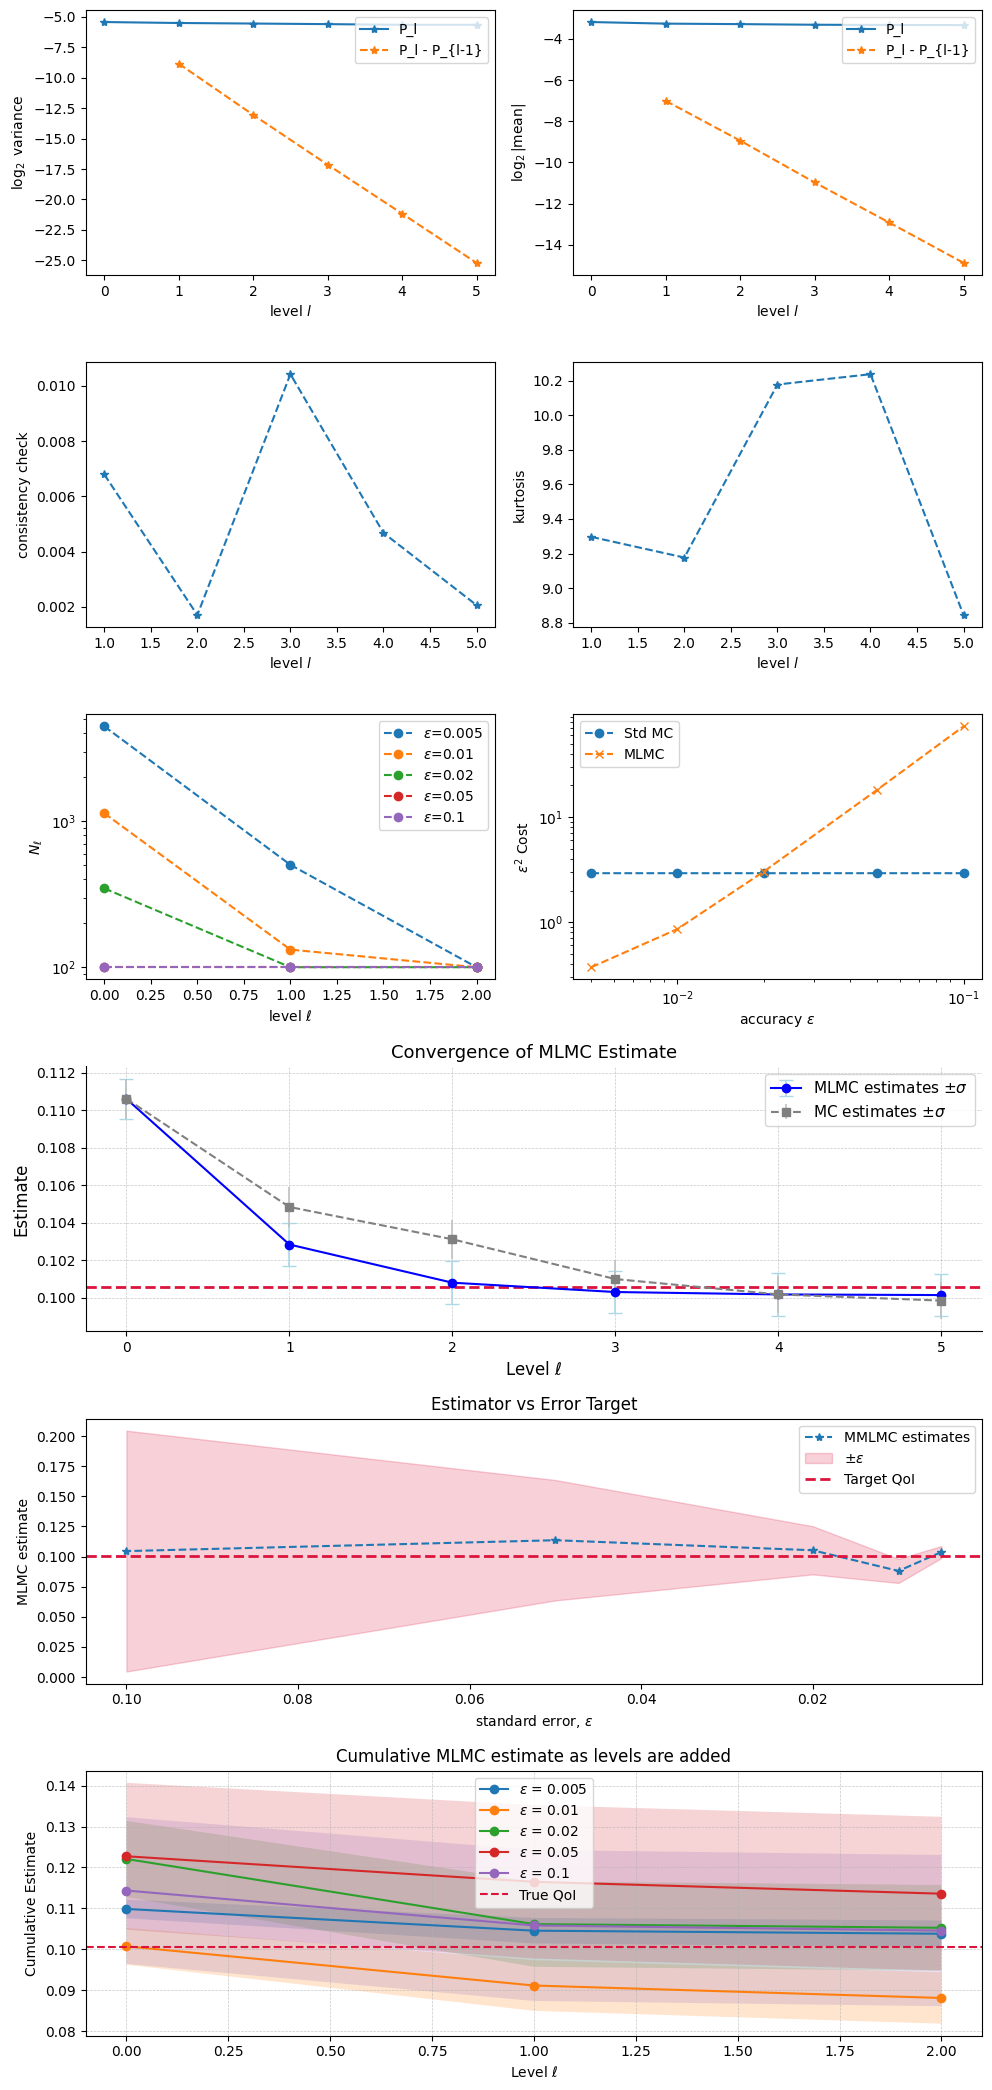

In [9]:
true_var = lambda n: (1 - np.exp(- 2 * n**2 * np.pi**2 * 0.25)) / (n**2 * np.pi**2)
cpp_outputs_plotting(complexity_path='../mlmc_cpp/outputs/mlmc_complexity_stoch_heat_eqn_fourier_mode_var_fe.csv',
                    convergence_path='../mlmc_cpp/outputs/mlmc_convergence_stoch_heat_eqn_fourier_mode_var_fe.csv',
                    validation_value=true_var(1))

/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_67197/3901515700.py:115: RuntimeWarning: invalid value encountered in divide
  se_array = np.sqrt(np.cumsum(Vl / Nl))


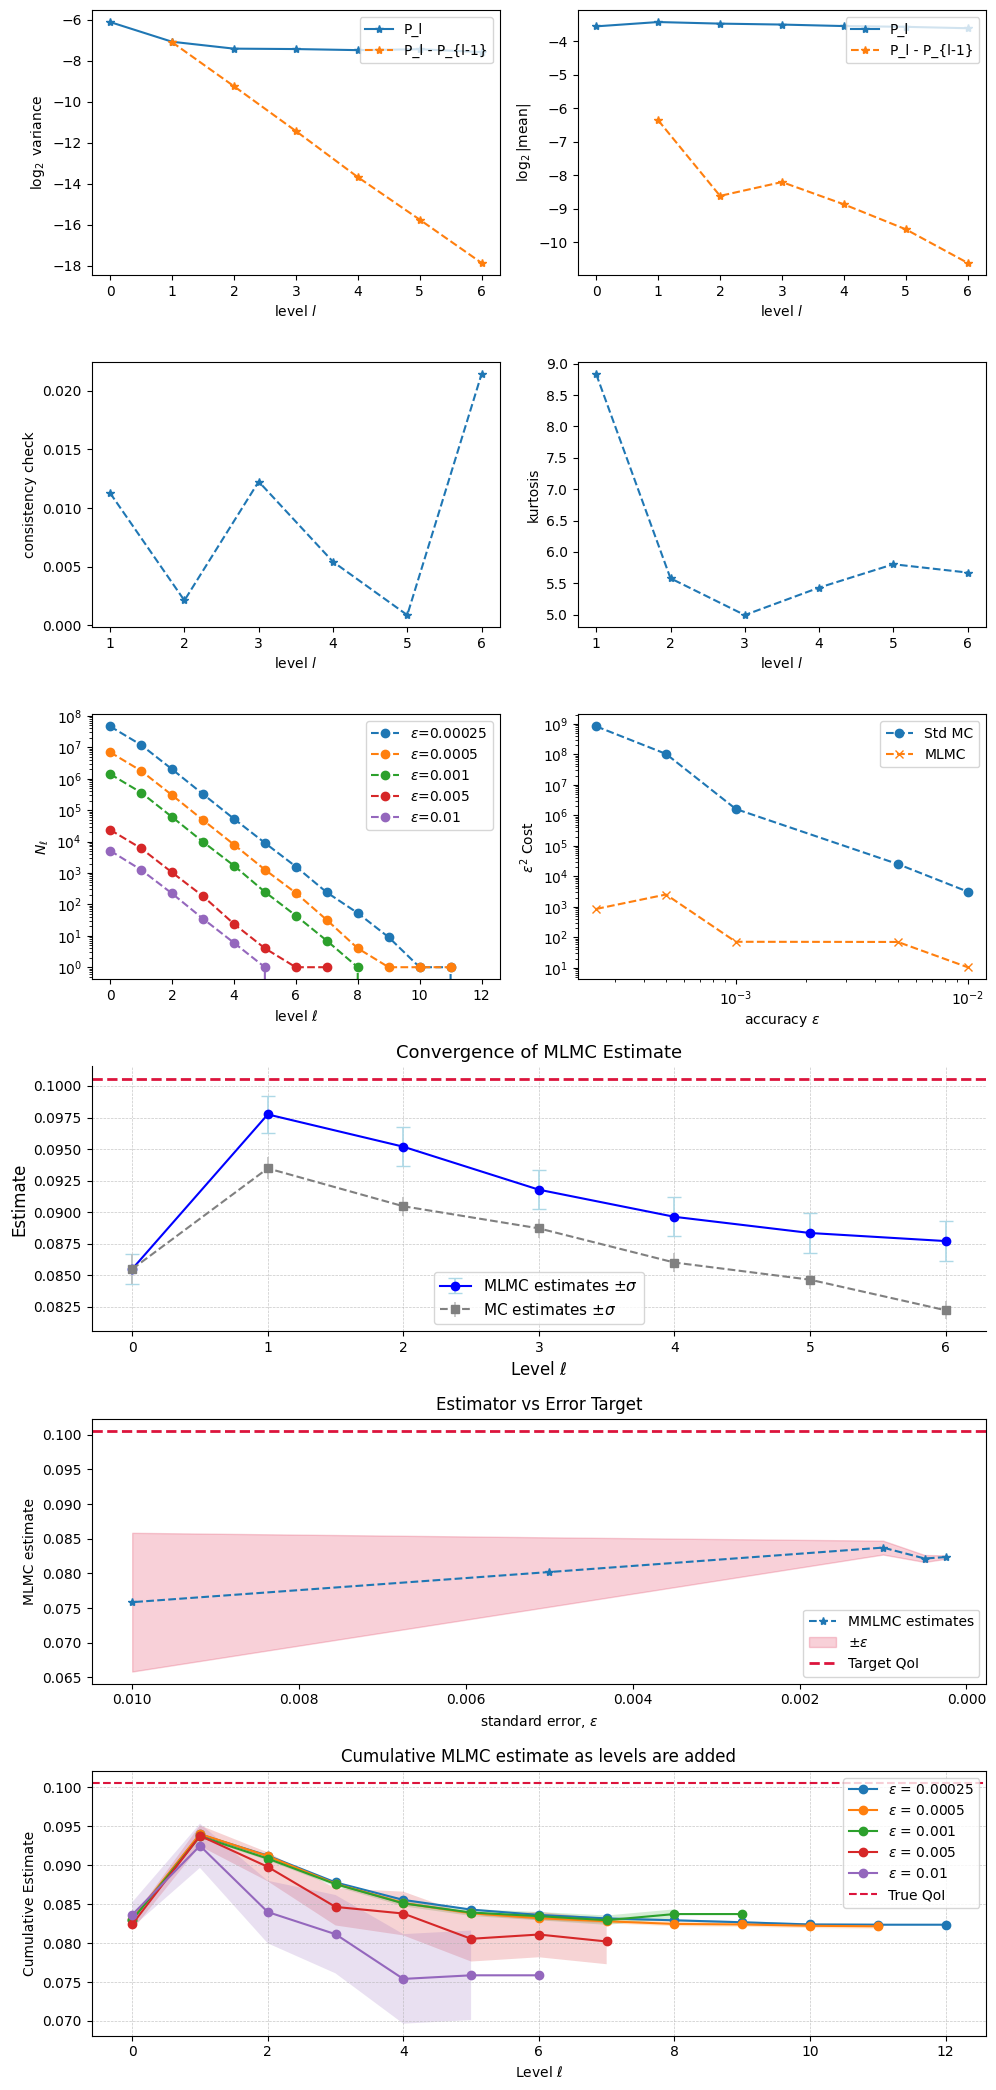

In [11]:
true_var = lambda n: (1 - np.exp(- 2 * n**2 * np.pi**2 * 0.25)) / (n**2 * np.pi**2)
cpp_outputs_plotting(complexity_path='../mlmc_cpp/outputs/mlmc_complexity_stoch_heat_eqn_energy_cc.csv',
                    convergence_path='../mlmc_cpp/outputs/mlmc_convergence_stoch_heat_eqn_energy_cc.csv',
                    validation_value=true_var(1))

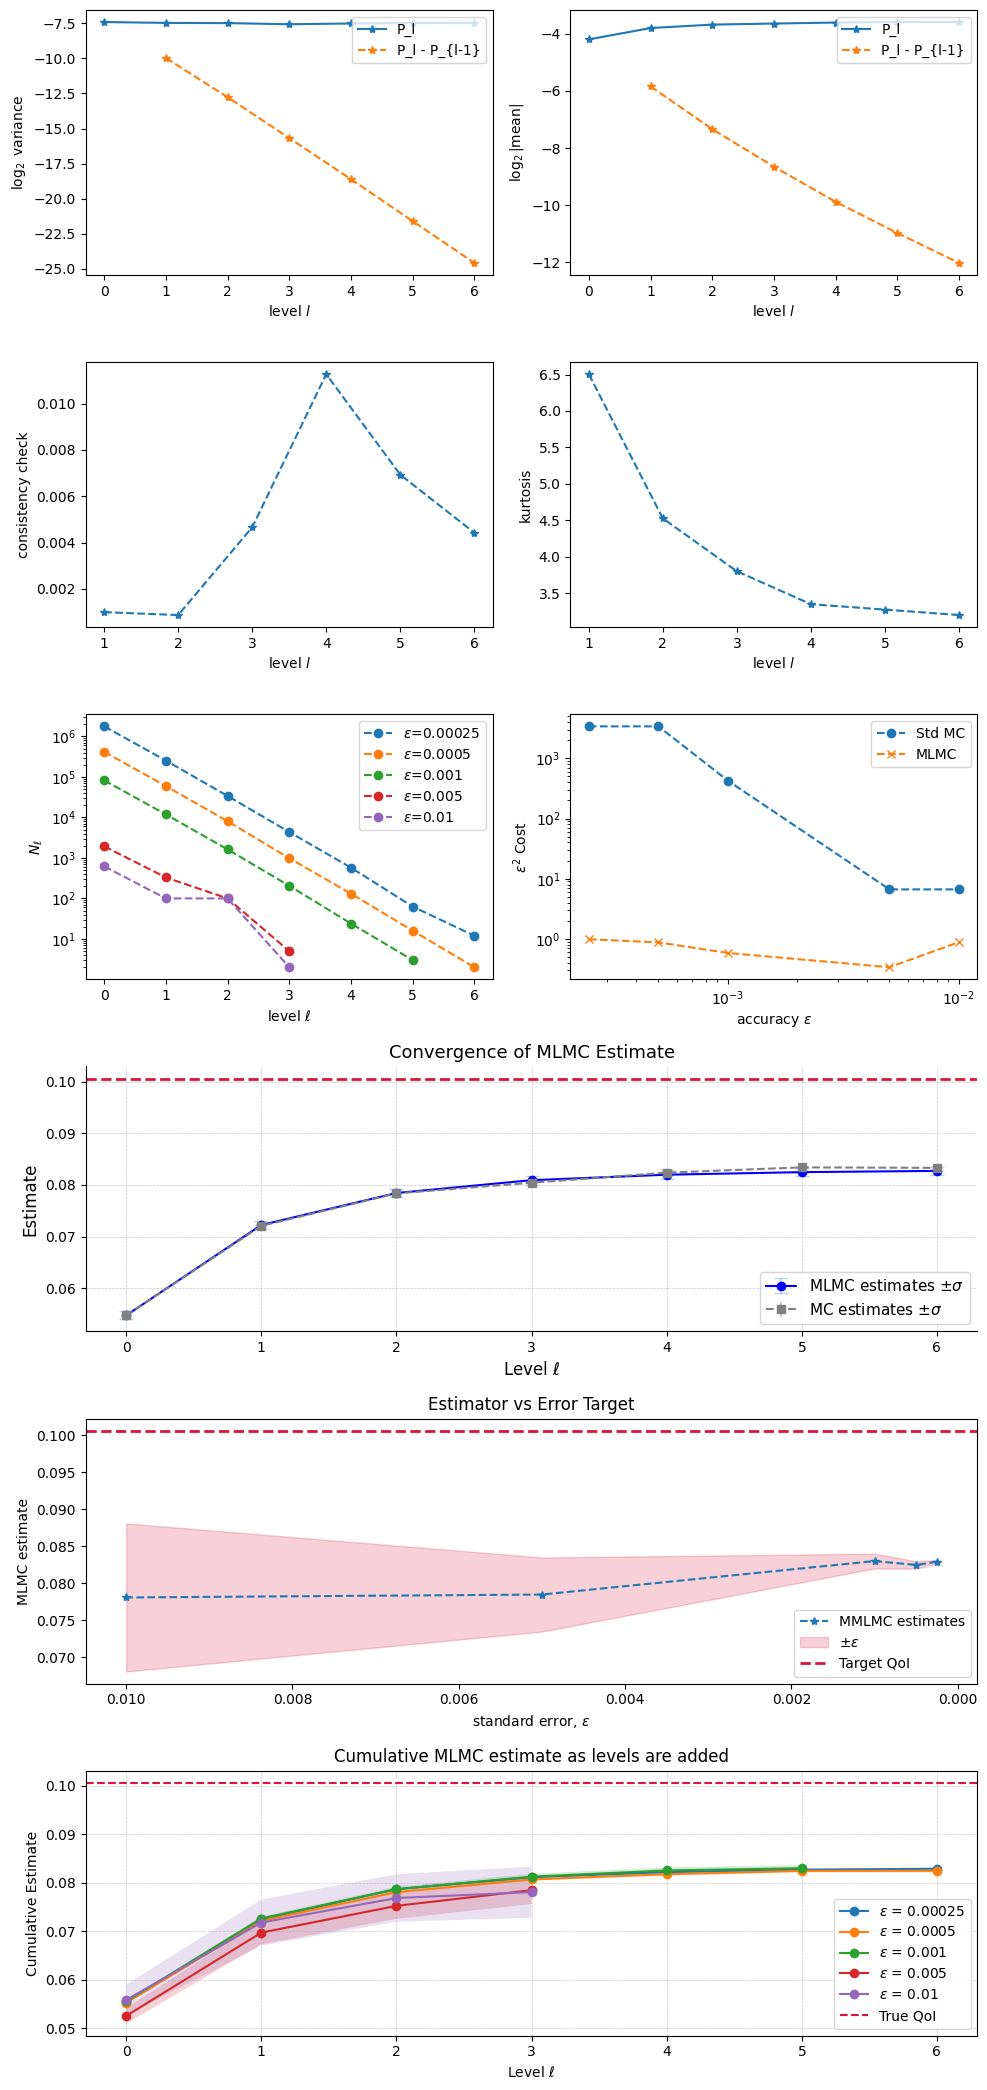

In [12]:
true_var = lambda n: (1 - np.exp(- 2 * n**2 * np.pi**2 * 0.25)) / (n**2 * np.pi**2)
cpp_outputs_plotting(complexity_path='../mlmc_cpp/outputs/mlmc_complexity_stoch_heat_eqn_energy_fe.csv',
                    convergence_path='../mlmc_cpp/outputs/mlmc_convergence_stoch_heat_eqn_energy_fe.csv',
                    validation_value=true_var(1))

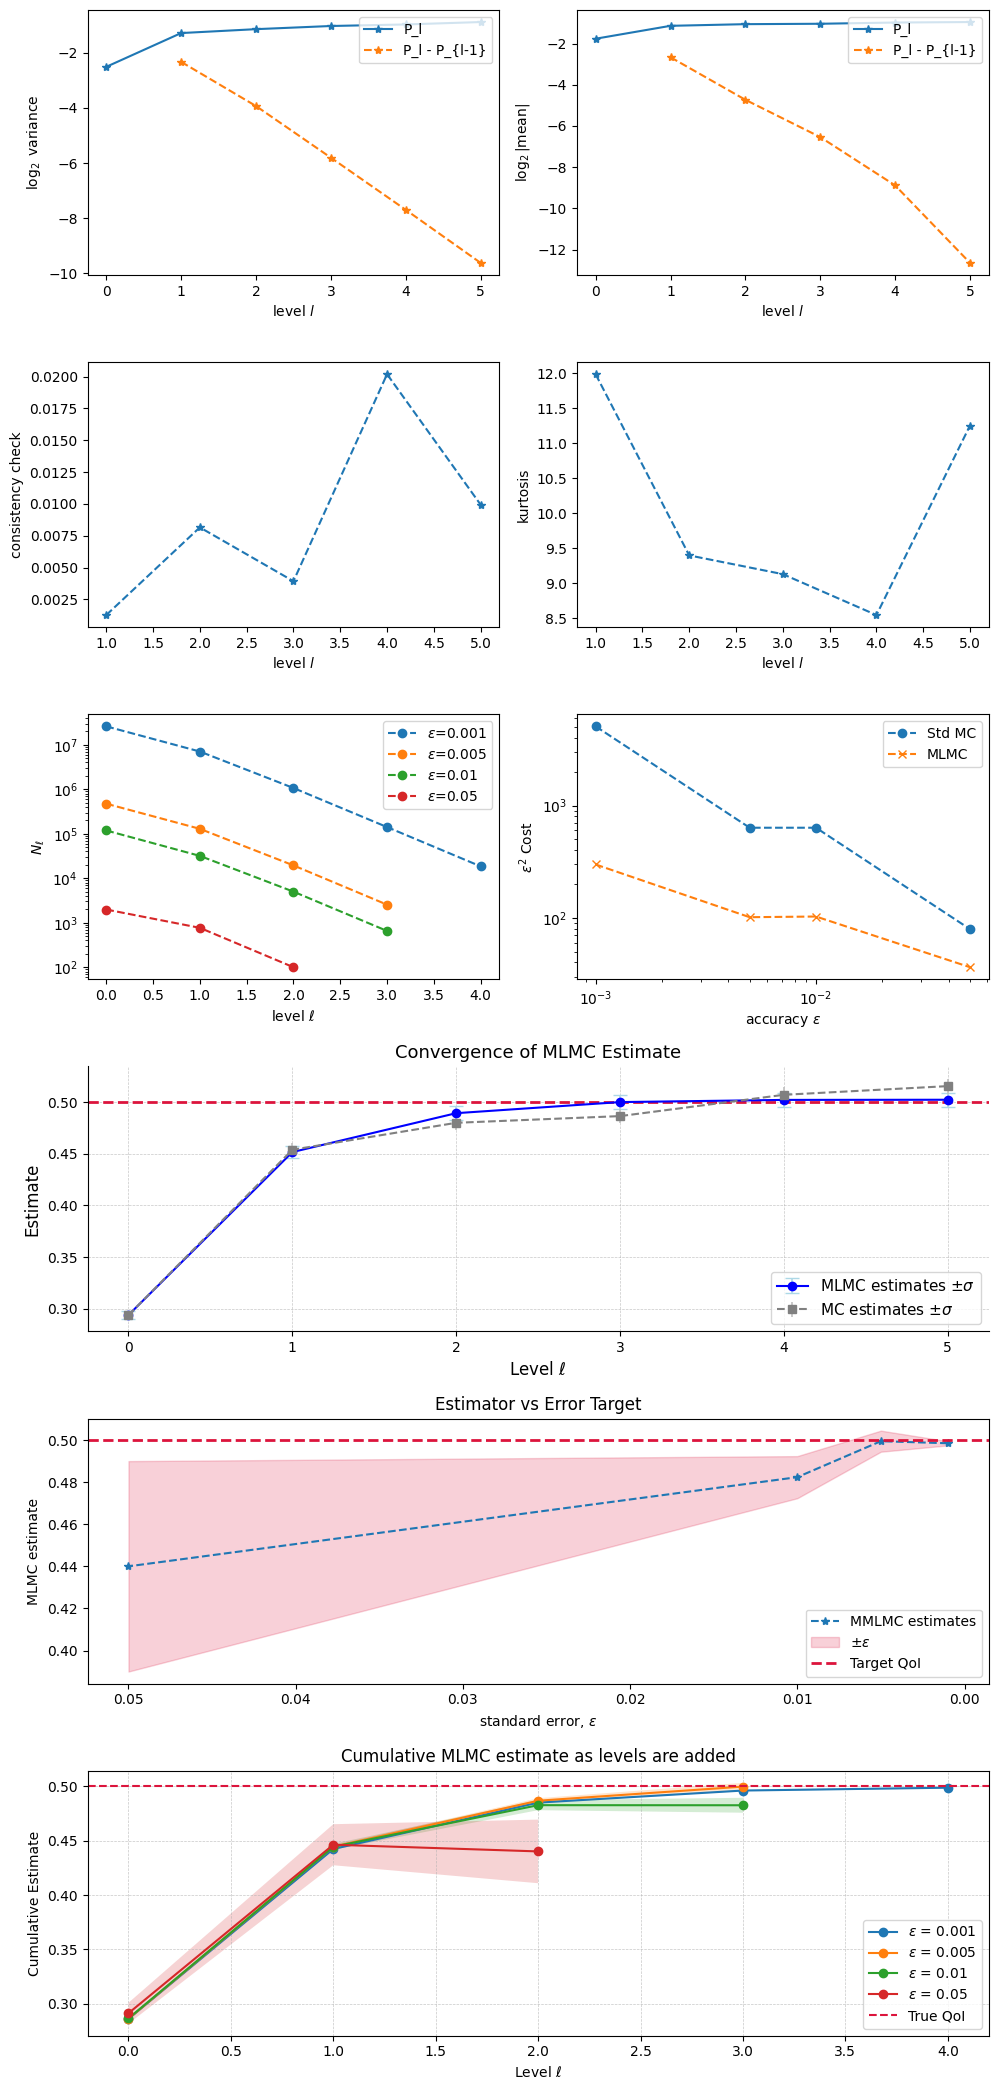

In [7]:
true_var = 0.4999752067807876
cpp_outputs_plotting(complexity_path='../mlmc_cpp/outputs/mlmc_complexity_dk_nn.csv',
                    convergence_path='../mlmc_cpp/outputs/mlmc_convergence_dk_nn.csv',
                    validation_value=true_var)

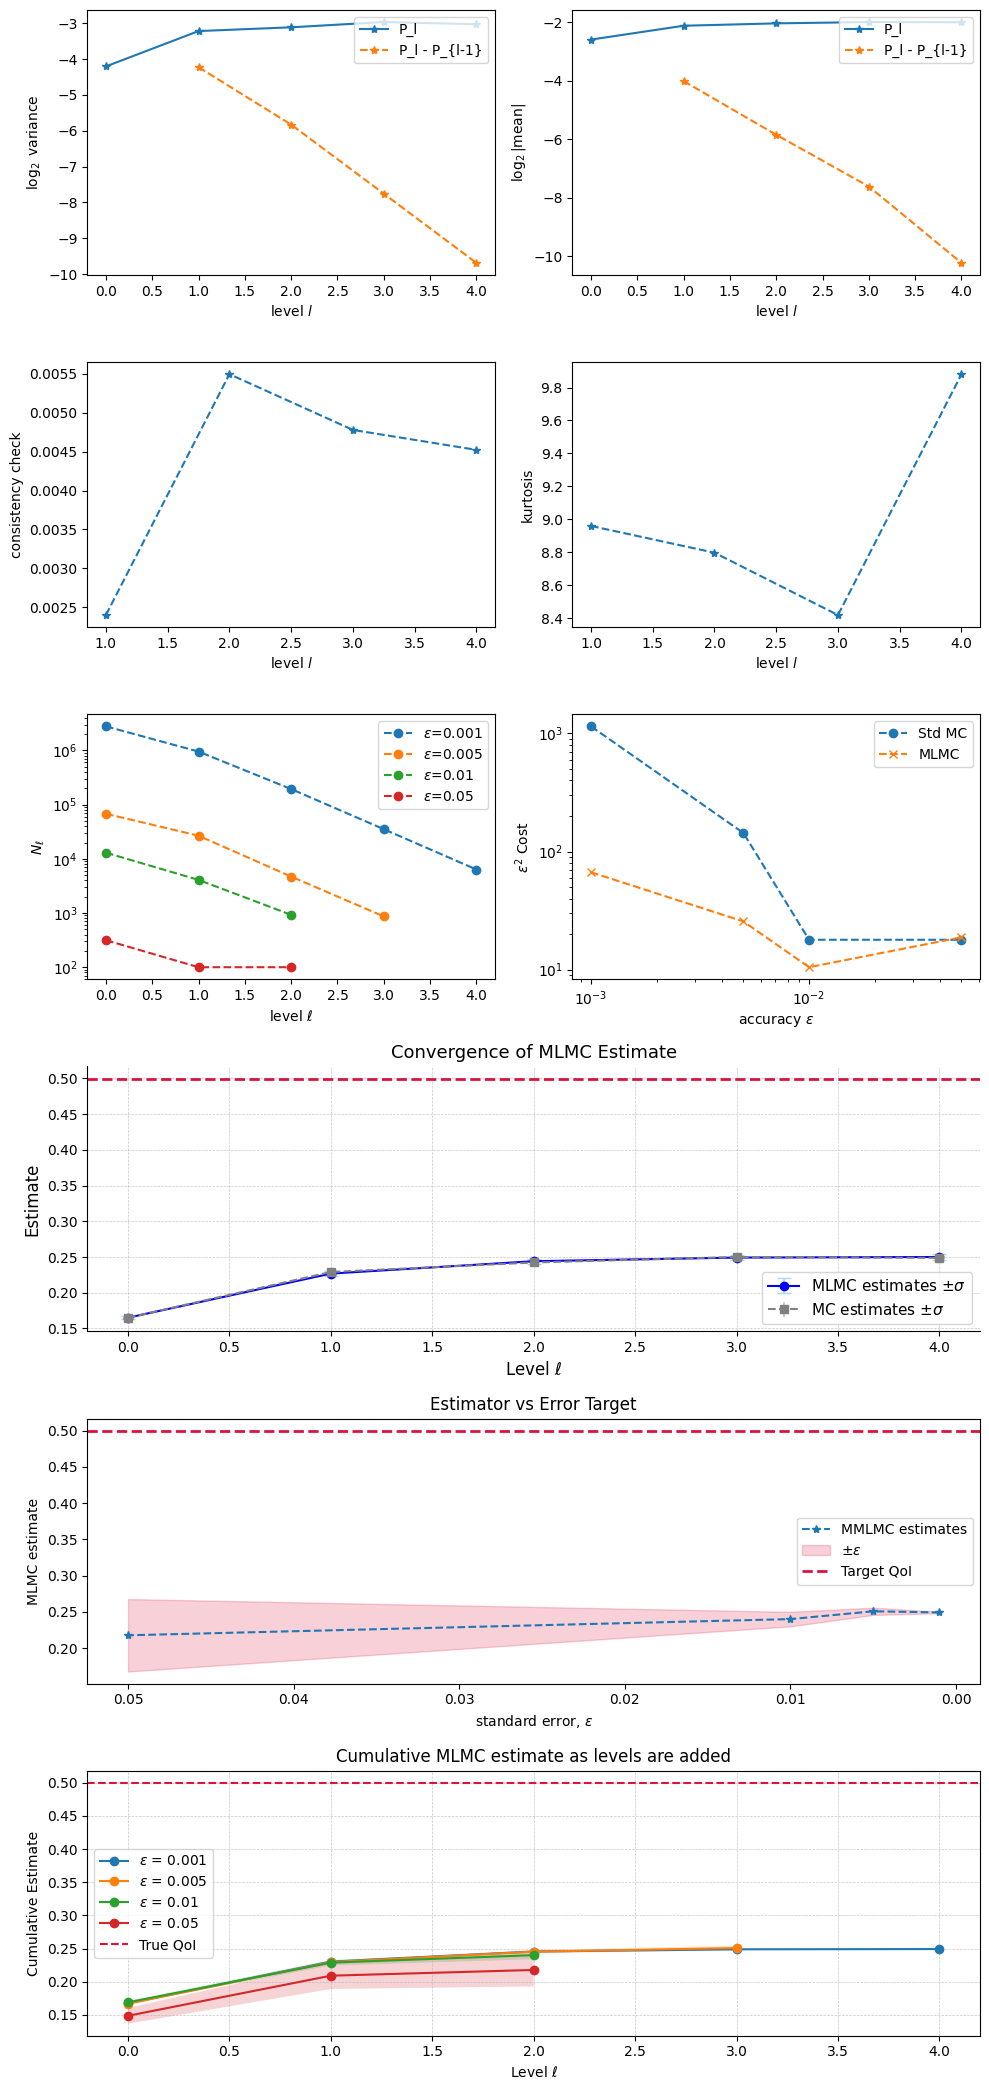

In [8]:
true_var = 0.4999752067807876
cpp_outputs_plotting(complexity_path='../mlmc_cpp/outputs/mlmc_complexity_dk_cc.csv',
                    convergence_path='../mlmc_cpp/outputs/mlmc_convergence_dk_cc.csv',
                    validation_value=true_var)